In [135]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


warnings.filterwarnings('ignore')

In [127]:
IMG_HEIGHT, IMG_WIDTH = 256, 256
EPOCHS = 250
BATCH_SIZE = 16
LEARNING_RATE = 0.001
THRESHOLD_DENSE = 0.5
THRESHOLD_UNET = 0.5

In [5]:
def load_data(img_dir, mask_dir):
    images = []
    masks = []
    img_files = sorted(os.listdir(img_dir), key=lambda x: int(x.split('.')[0]))
    mask_files = sorted(os.listdir(mask_dir), key=lambda x: int(x.split('.')[0]))

    for img_file, mask_file in zip(img_files, mask_files):
        img = tf.keras.preprocessing.image.load_img(
            os.path.join(img_dir, img_file),
            target_size=(IMG_HEIGHT, IMG_WIDTH),
        )
        mask = tf.keras.preprocessing.image.load_img(
            os.path.join(mask_dir, mask_file),
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            color_mode='grayscale',
        )
        images.append(np.array(img) / 255.0)
        masks.append(np.array(mask) / 255.0)
    return np.array(images), np.array(masks)

In [133]:
def build_dense_model():
    model = models.Sequential([
        layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(IMG_HEIGHT * IMG_WIDTH, activation='sigmoid'),
        layers.Reshape((IMG_HEIGHT, IMG_WIDTH, 1))
    ])
    return model

In [132]:
def build_unet():
    inputs = layers.Input((IMG_HEIGHT, IMG_WIDTH, 3))

    # Encoder
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = models.Model(inputs, outputs)
    return model

In [128]:
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        loss = -alpha * (1 - y_pred) ** gamma * y_true * tf.math.log(y_pred) \
               - (1 - alpha) * y_pred ** gamma * (1 - y_true) * tf.math.log(1 - y_pred)
        return tf.reduce_mean(loss)
    return loss

In [129]:
def f1_score_(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [130]:
def evaluate_model(model, X_test, Y_test, threshold=0.5):
    preds = model.predict(X_test)
    preds_binary = (preds > threshold).astype(np.int32)
    
    preds_flat = preds_binary.flatten()
    Y_test_flat = Y_test.flatten().astype(np.int32)
    
    metrics = {
        "Accuracy": accuracy_score(Y_test_flat, preds_flat),
        "Precision": precision_score(Y_test_flat, preds_flat, zero_division=0),
        "Recall": recall_score(Y_test_flat, preds_flat, zero_division=0),
        "F1-Score": f1_score(Y_test_flat, preds_flat, zero_division=0),
        "ROC-AUC": roc_auc_score(Y_test_flat, preds)
    }
    return metrics

In [131]:
def visualize_predictions(X_test, Y_test, preds, num_images=7, image_per_row=5):
    num_rows = (num_images + 4) // 5 * 3
    print(num_rows)
    plt.figure(figsize=(15, 25))
    for i in range(num_images):
        plt.subplot(num_rows, 5, (i//image_per_row)*15+(i%image_per_row)+1)
        plt.imshow(X_test[i])
        plt.title("Input")
        plt.axis("off")
        
        plt.subplot(num_rows, 5, (i//image_per_row)*15+(i%image_per_row)+6)
        plt.imshow(Y_test[i].squeeze(), cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")
        
        plt.subplot(num_rows, 5, (i//image_per_row)*15+(i%image_per_row)+11)
        plt.imshow(preds[i].squeeze(), cmap="gray")
        plt.title("Prediction")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [11]:
IMG_DIR = "data/imgs"
MASK_DIR = "data/masks"

X, Y = load_data(IMG_DIR, MASK_DIR)
Y = np.expand_dims(Y, axis=-1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### <center>Fully_connected_neural_network

In [136]:
dense_model = build_dense_model()
dense_model.compile(optimizer=Adam(LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy', f1_score_, 'AUC'])
dense_model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2);

Epoch 1/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 763ms/step - AUC: 0.5616 - accuracy: 0.3410 - f1_score_: 0.2812 - loss: 0.6311 - val_AUC: 0.7451 - val_accuracy: 0.5150 - val_f1_score_: 0.8266 - val_loss: 0.3026
Epoch 2/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 595ms/step - AUC: 0.7148 - accuracy: 0.4715 - f1_score_: 0.6687 - loss: 0.3480 - val_AUC: 0.7183 - val_accuracy: 0.5136 - val_f1_score_: 0.7795 - val_loss: 0.2749
Epoch 3/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 594ms/step - AUC: 0.7242 - accuracy: 0.5036 - f1_score_: 0.7233 - loss: 0.2942 - val_AUC: 0.7136 - val_accuracy: 0.5215 - val_f1_score_: 0.8440 - val_loss: 0.2612
Epoch 4/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 607ms/step - AUC: 0.7202 - accuracy: 0.5252 - f1_score_: 0.7300 - loss: 0.2891 - val_AUC: 0.6810 - val_accuracy: 0.5214 - val_f1_score_: 0.8645 - val_loss: 0.2356
Epoch 5/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 552ms/step - AUC: 0.6799 - accuracy: 0.4972 - f1_score_: 0.7995 - loss: 0.2686 - val_AUC: 0.7199 - val_accuracy: 0.5279 - val_f1_score_: 0.8585 - va

In [137]:
dense_metrics = evaluate_model(dense_model, X_test, Y_test, threshold=THRESHOLD_DENSE)
print("Metrics for Dense Model:", dense_metrics)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Metrics for Dense Model: {'Accuracy': 0.8694145202636718, 'Precision': 0.5302312786150792, 'Recall': 0.8538204753642754, 'F1-Score': 0.6541985457675127}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
12


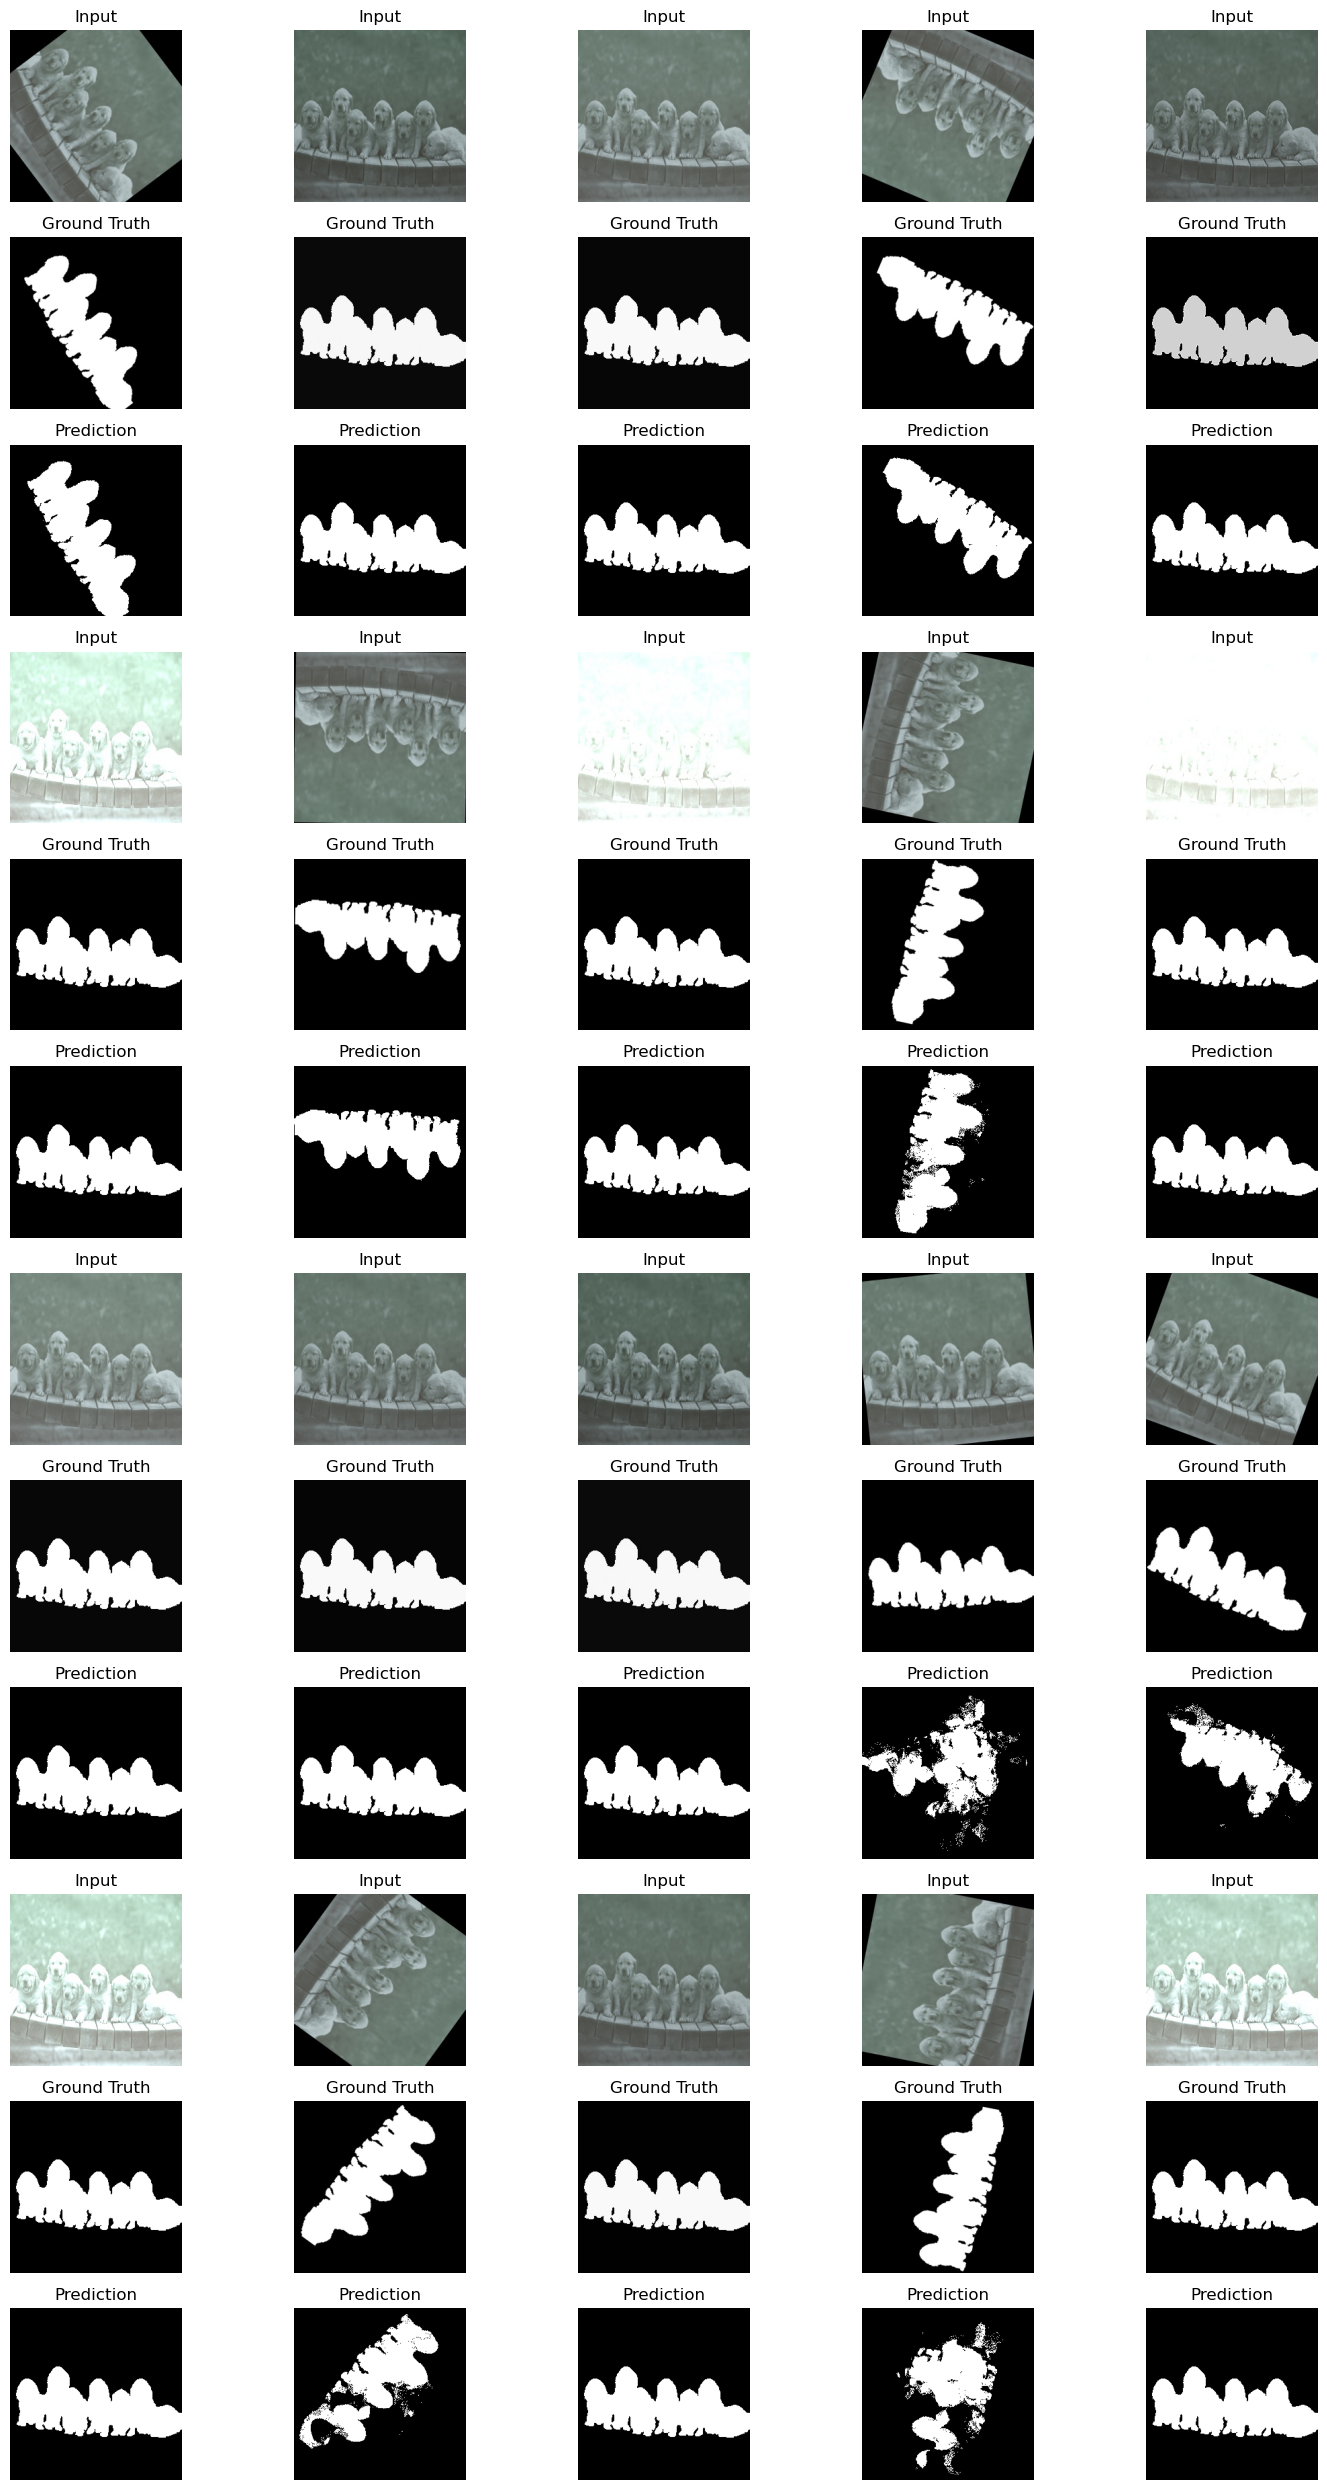

In [138]:
preds_dense = (dense_model.predict(X_test) > THRESHOLD_DENSE).astype(np.float32)
visualize_predictions(X_test, Y_test, preds_dense, num_images=Y_test.shape[0])

### <center>U-Net

In [139]:
unet_model = build_unet()
unet_model.compile(optimizer=Adam(LEARNING_RATE), loss=focal_loss(alpha=0.25, gamma=5.0), metrics=['accuracy', f1_score_, 'AUC'])
unet_model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2);

Epoch 1/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - AUC: 0.5083 - accuracy: 0.3138 - f1_score_: 0.1120 - loss: 0.0136 - val_AUC: 0.5798 - val_accuracy: 0.4583 - val_f1_score_: 0.0000e+00 - val_loss: 0.0114
Epoch 2/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - AUC: 0.5707 - accuracy: 0.4332 - f1_score_: 0.0000e+00 - loss: 0.0111 - val_AUC: 0.5766 - val_accuracy: 0.4583 - val_f1_score_: 0.0000e+00 - val_loss: 0.0089
Epoch 3/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - AUC: 0.6202 - accuracy: 0.4315 - f1_score_: 0.0000e+00 - loss: 0.0088 - val_AUC: 0.5747 - val_accuracy: 0.4583 - val_f1_score_: 0.0000e+00 - val_loss: 0.0093
Epoch 4/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - AUC: 0.5948 - accuracy: 0.4863 - f1_score_: 0.0000e+00 - loss: 0.0089 - val_AUC: 0.5819 - val_accuracy: 0.4583 - val_f1_score_: 0.0000e+00 - val_loss: 0.0084
Epoch 5/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - AUC: 0.5953 - accuracy: 0.4392 - f1_score_: 0.0000e+00 - loss: 0.0082 - val_AUC: 0.5835 - val_accuracy: 0.4583 - val_f1_s

In [140]:
unet_metrics = evaluate_model(unet_model, X_test, Y_test, threshold=THRESHOLD_UNET)
print("Metrics for Unet Model:", unet_metrics)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Metrics for Unet Model: {'Accuracy': 0.8913963317871094, 'Precision': 0.5825844816502223, 'Recall': 0.879350078840647, 'F1-Score': 0.7008462946500812}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
12


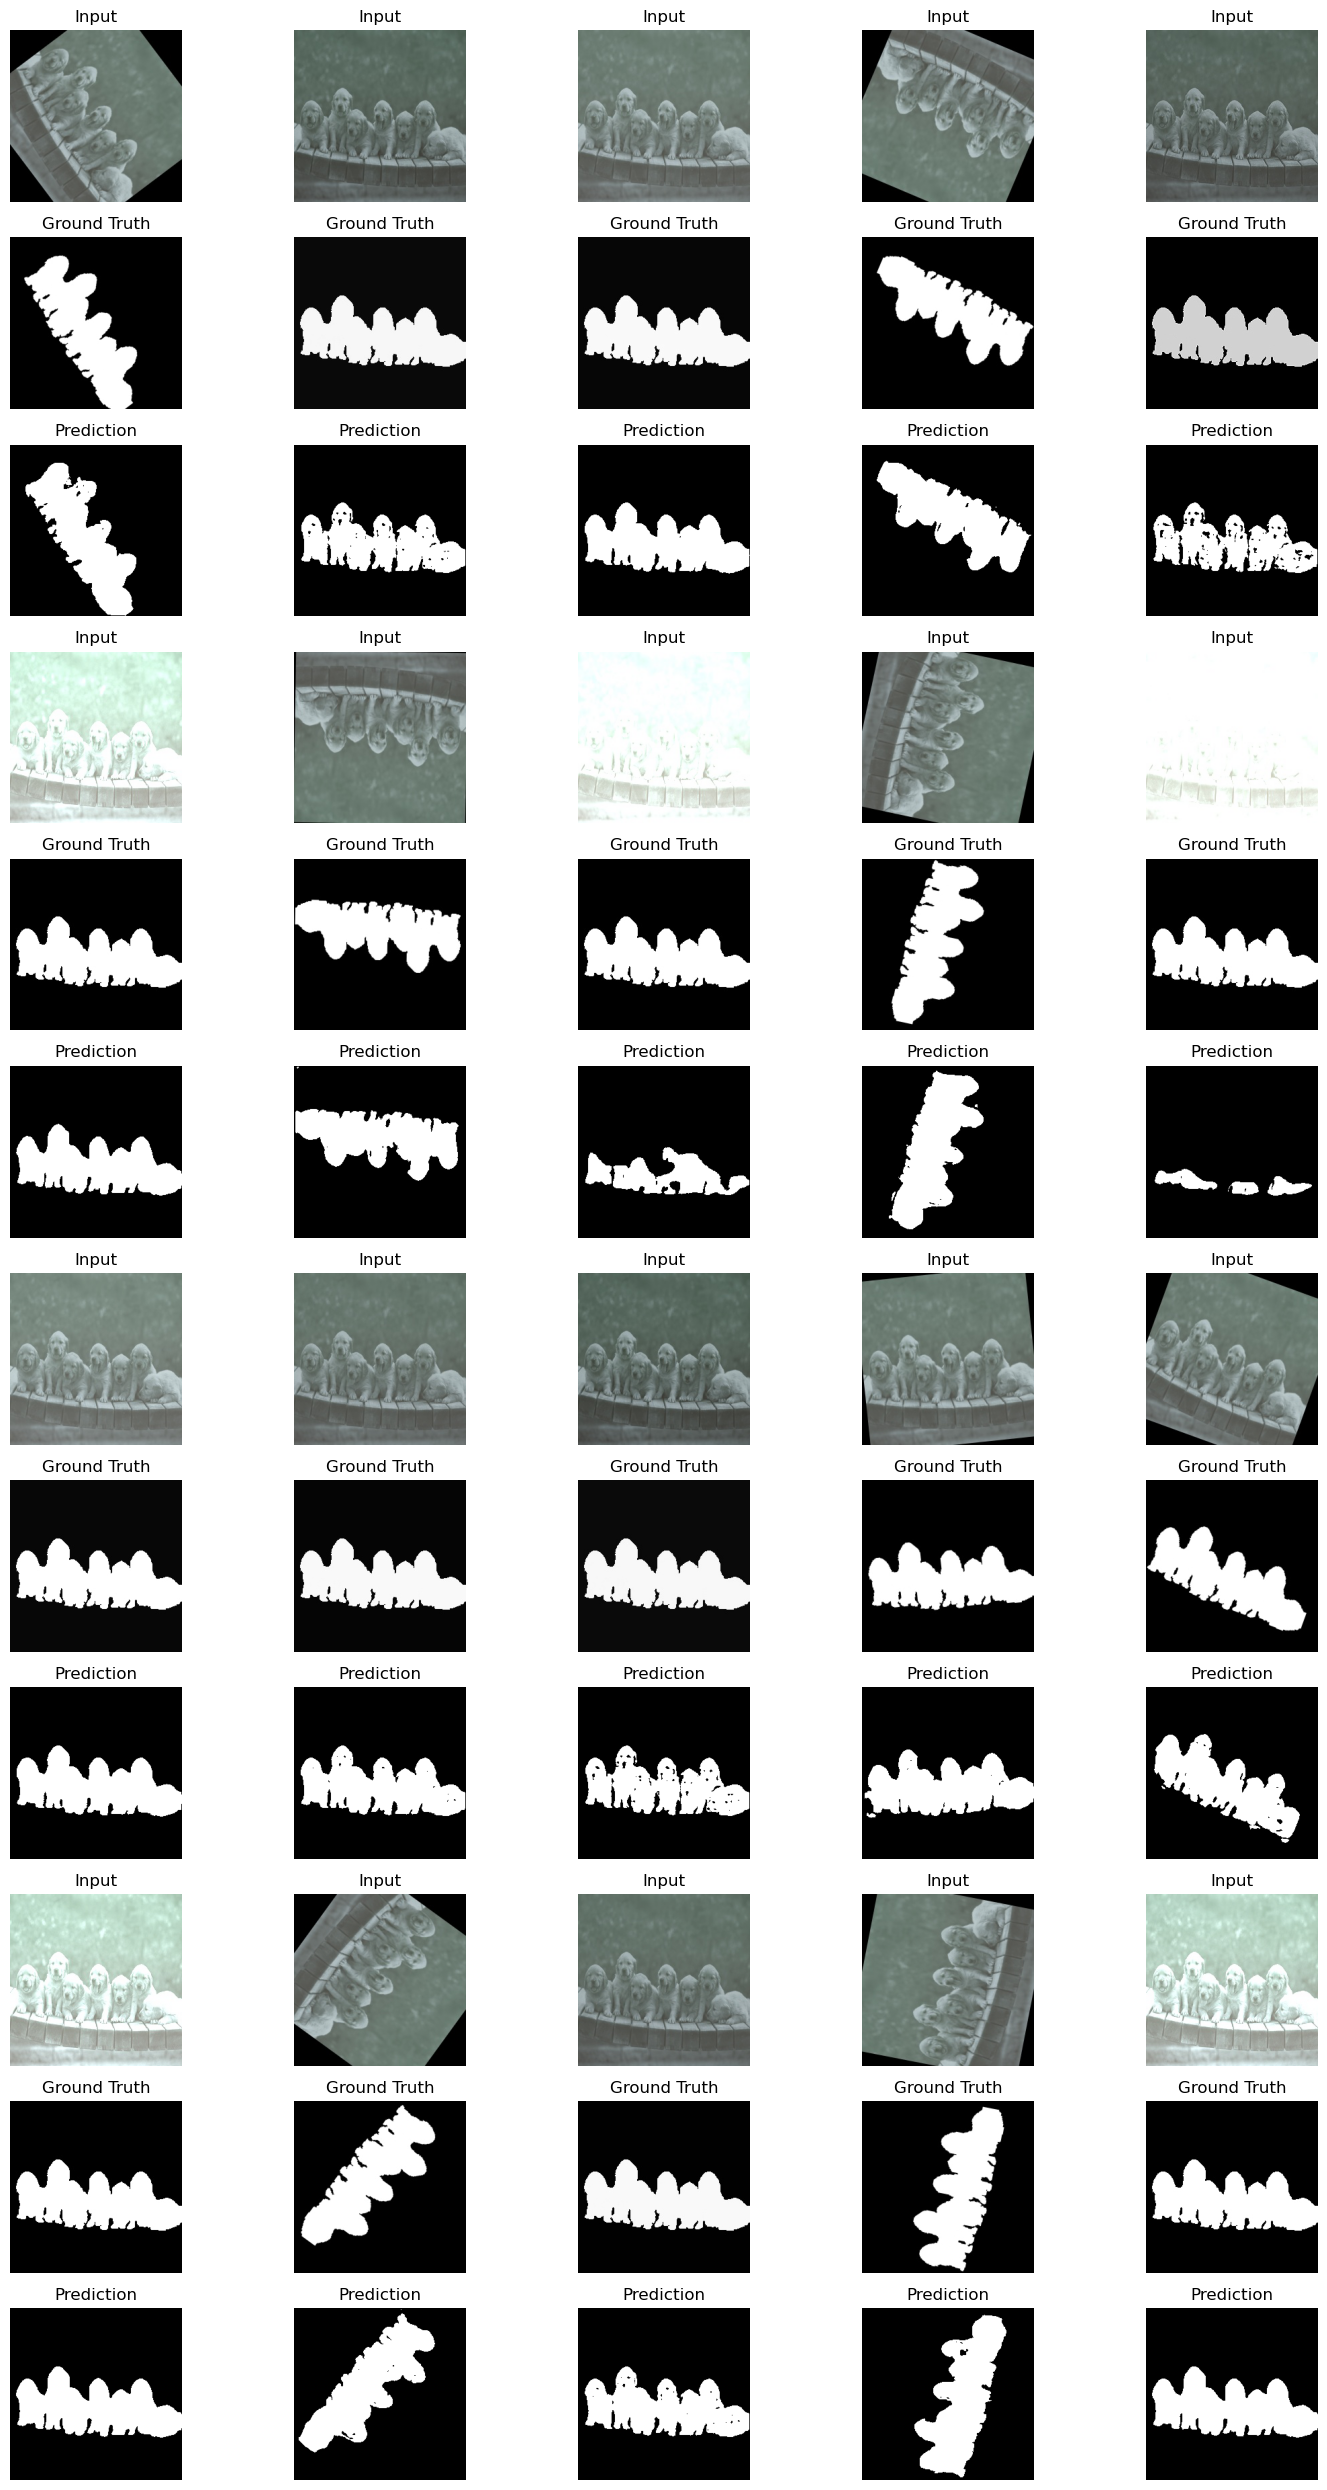

In [143]:
preds_unet = (unet_model.predict(X_test) > THRESHOLD_UNET).astype(np.float32)
visualize_predictions(X_test, Y_test, preds_unet, num_images=Y_test.shape[0])